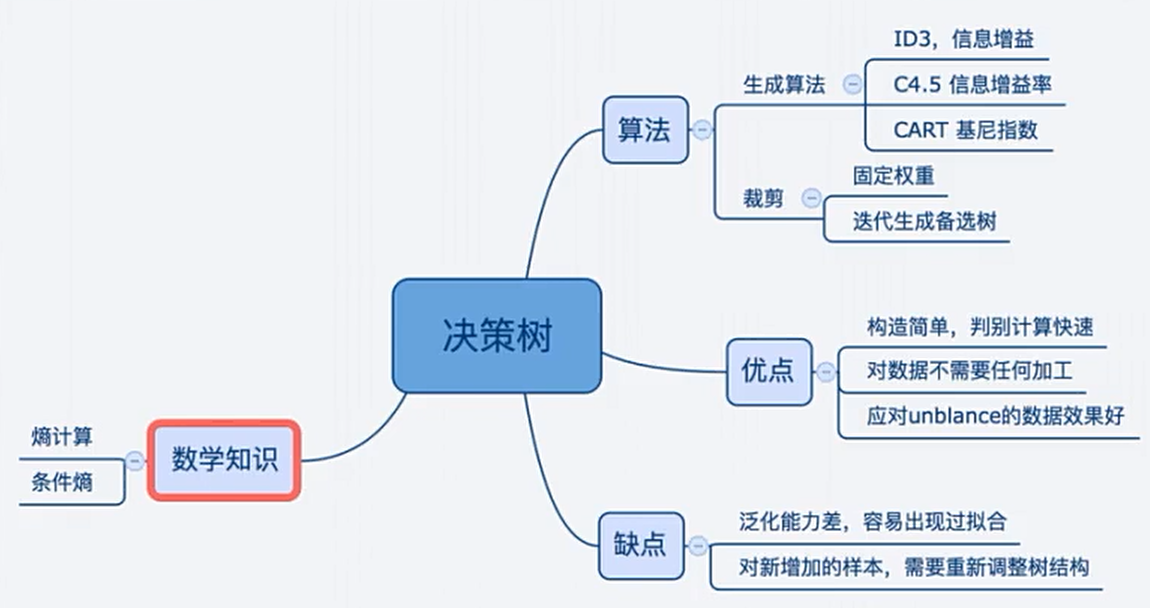

# 决策树的优点
主要是决策树对数据不需要任何加工这一点，即是说即便我们的数据的feature不完整，比如某样本有的feature没有采集到，我们依然可以利用这个样本去训练我们的算法，在分叉时，没有用到这个feature，样本依然可以使用；不像线性的算法那样，theta.T * x，如果有feature缺失，我们需要考虑补什么。

由于决策树是利用纯粹的性质来分类，所以对于那些小类的数据，对于非平衡的数据，越到下面，会越来越平衡。

# 集成学习算法
不论什么分类器，最后我们都会通过集成学习算法，这是必用的。

而集成学习算法有两大利器：bagging（rf最为常用）+boosting（adaboost最为常用）

# 随机森林算法
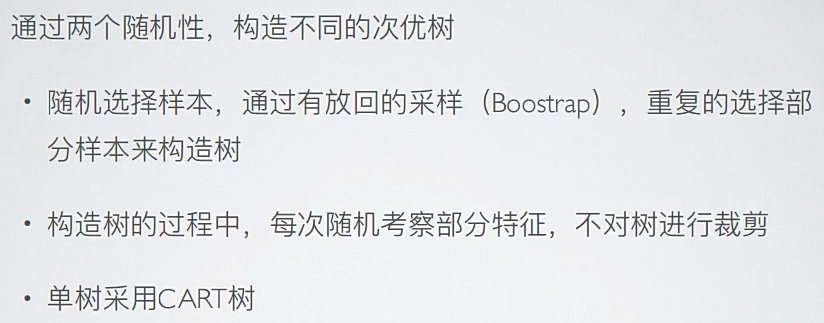
最后在生成了一定数目的次优树之后，RF采用多数投票法（针对分类）或单颗树输出结果的简单平均（针对回归）得到。

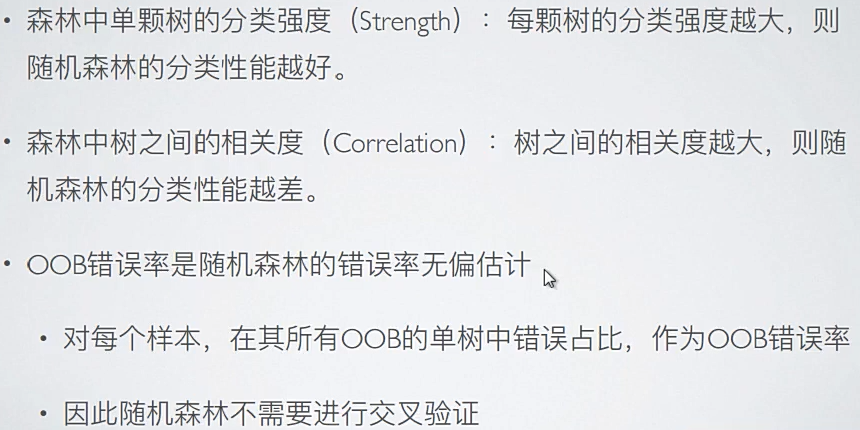

In [1]:
from random import seed, randrange, random

In [3]:
def loadDataSet(filename):
    dataset = []
    with open(filename, 'r') as fr:
        for line in fr.readlines():
            if not line:
                continue
            lineArr = []
            for featrue in line.split(','):
                # strip()返回移除字符串头尾指定的字符生成的新字符串
                str_f = featrue.strip()

                # isdigit 如果是浮点型数值，就是 false，所以换成 isalpha() 函数
                # if str_f.isdigit():   # 判断是否是数字
                
                if str_f.isalpha():     # 如果是字母，说明是标签
                    # 添加分类标签
                    lineArr.append(str_f)
                else:
                    # 将数据集的第column列转换成float形式
                    lineArr.append(float(str_f))
            dataset.append(lineArr)
    return dataset

In [7]:
def cross_validation_split(dataset, n_folds):
    """cross_validation_split(将数据集进行抽重抽样 n_folds 份，数据可以重复重复抽取，每一次list的元素是无重复的)

    Args:
        dataset     原始数据集
        n_folds     数据集dataset分成n_flods份
    Returns:
        dataset_split    list集合，存放的是：将数据集进行抽重抽样 n_folds 份，数据可以重复重复抽取，每一次list的元素是无重复的
    """
    dataset_split = list()
    dataset_copy = list(dataset)       # 复制一份 dataset,防止 dataset 的内容改变
    fold_size = len(dataset) / n_folds
    for i in range(n_folds):
        fold = list()                  # 每次循环 fold 清零，防止重复导入 dataset_split
        while len(fold) < fold_size:   # 这里不能用 if，if 只是在第一次判断时起作用，while 执行循环，直到条件不成立
            # 有放回的随机采样，有一些样本被重复采样，从而在训练集中多次出现，有的则从未在训练集中出现，此则自助采样法。
            #从而保证每棵决策树训练集的差异性            
            index = randrange(len(dataset_copy))
            # 将对应索引 index 的内容从 dataset_copy 中导出，并将该内容从 dataset_copy 中删除。
            # pop() 函数用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值。
            # fold.append(dataset_copy.pop(index))  # 无放回的方式
            # 有放回在数据量较小时比较好，数据量较大时，有放回、无放回都一样
            fold.append(dataset_copy[index])  # 有放回的方式
        dataset_split.append(fold)
    # 由dataset分割出的n_folds个数据构成的列表，为了用于交叉验证
    return dataset_split

In [8]:
# Split a dataset based on an attribute and an attribute value # 根据特征和特征值分割数据集
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [11]:
'''
Gini指数的计算问题，假如将原始数据集D切割两部分，分别为D1和D2，则
Gini(D|切割) = (|D1|/|D| ) * Gini(D1) + (|D2|/|D|) * Gini(D2)
学习地址：http://bbs.pinggu.org/thread-5986969-1-1.html
而原文中 计算方式为：
Gini(D|切割) = Gini(D1) + Gini(D2)
'''
def gini_index(groups, class_values):    # 个人理解：计算代价，分类越准确，则 gini 越小
    gini = 0.0
    D = len(groups[0]) + len(groups[1])
    for class_value in class_values:     # class_values = [0, 1]
        for group in groups:             # groups = (left, right)
            size = len(group)
            if size == 0:
                continue
            proportion = [row[-1] for row in group].count(class_value) / float(size)
            gini += float(size)/D * (proportion * (1.0 - proportion))    # 个人理解：计算代价，分类越准确，则 gini 越小
    return gini

In [12]:
# 找出分割数据集的最优特征，得到最优的特征 index，特征值 row[index]，以及分割完的数据 groups（left, right）
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))  # class_values =[0, 1]
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)  # 往 features 添加 n_features 个特征（ n_feature 等于特征数的根号），特征索引从 dataset 中随机取
        if index not in features:
            features.append(index)
    for index in features:                    # 在 n_features 个特征中选出最优的特征索引，并没有遍历所有特征，从而保证了每课决策树的差异性
        for row in dataset:
            groups = test_split(index, row[index], dataset)  # groups=(left, right), row[index] 遍历每一行 index 索引下的特征值作为分类值 value, 找出最优的分类特征和特征值
            gini = gini_index(groups, class_values)
            # 左右两边的数量越一样，说明数据区分度不高，gini系数越大
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups  # 最后得到最优的分类特征 b_index,分类特征值 b_value,分类结果 b_groups。b_value 为分错的代价成本
    # print b_score
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

In [13]:
# Create a terminal node value # 输出group中出现次数较多的标签
def to_terminal(group):
    outcomes = [row[-1] for row in group]           # max() 函数中，当 key 参数不为空时，就以 key 的函数对象为判断的标准
    return max(set(outcomes), key=outcomes.count)   # 输出 group 中出现次数较多的标签  

In [14]:
# Create child splits for a node or make terminal  # 创建子分割器，递归分类，直到分类结束
def split(node, max_depth, min_size, n_features, depth):  # max_depth = 10, min_size = 1, n_features = int(sqrt((dataset[0])-1))
    left, right = node['groups']
    del(node['groups'])
# check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
# check for max depth
    if depth >= max_depth:   # max_depth=10 表示递归十次，若分类还未结束，则选取数据中分类标签较多的作为结果，使分类提前结束，防止过拟合
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
# process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)  # node['left']是一个字典，形式为{'index':b_index, 'value':b_value, 'groups':b_groups}，所以node是一个多层字典
        split(node['left'], max_depth, min_size, n_features, depth+1)  # 递归，depth+1计算递归层数
# process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

In [15]:
# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    """build_tree(创建一个决策树)

    Args:
        train           训练数据集
        max_depth       决策树深度不能太深，不然容易导致过拟合
        min_size        叶子节点的大小
        n_features      选取的特征的个数
    Returns:
        root            返回决策树
    """

    # 返回最优列和相关的信息
    root = get_split(train, n_features)

    # 对左右2边的数据 进行递归的调用，由于最优特征使用过，所以在后面进行使用的时候，就没有意义了
    # 例如： 性别-男女，对男使用这一特征就没任何意义了
    split(root, max_depth, min_size, n_features, 1)
    return root

In [16]:
# Make a prediction with a decision tree
def predict(node, row):   # 预测模型分类结果
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):       # isinstance 是 Python 中的一个内建函数。是用来判断一个对象是否是一个已知的类型。
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [18]:
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    """bagging_predict(bagging预测)

    Args:
        trees           决策树的集合
        row             测试数据集的每一行数据
    Returns:
        返回随机森林中，决策树结果出现次数做大的
    """

    # 使用多个决策树trees对测试集test的第row行进行预测，再使用简单投票法判断出该行所属分类
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)

In [20]:
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):   # 创建数据集的随机子样本
    """random_forest(评估算法性能，返回模型得分)

    Args:
        dataset         训练数据集
        ratio           训练数据集的样本比例
    Returns:
        sample          随机抽样的训练样本
    """

    sample = list()
    # 训练样本的按比例抽样。
    # round() 方法返回浮点数x的四舍五入值。
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        # 有放回的随机采样，有一些样本被重复采样，从而在训练集中多次出现，有的则从未在训练集中出现，此则自助采样法。从而保证每棵决策树训练集的差异性
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [21]:
# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    """random_forest(评估算法性能，返回模型得分)

    Args:
        train           训练数据集
        test            测试数据集
        max_depth       决策树深度不能太深，不然容易导致过拟合
        min_size        叶子节点的大小
        sample_size     训练数据集的样本比例
        n_trees         决策树的个数
        n_features      选取的特征的个数
    Returns:
        predictions     每一行的预测结果，bagging 预测最后的分类结果
    """

    trees = list()
    # n_trees 表示决策树的数量
    for i in range(n_trees):
        # 随机抽样的训练样本， 随机采样保证了每棵决策树训练集的差异性
        sample = subsample(train, sample_size)
        # 创建一个决策树
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)

    # 每一行的预测结果，bagging 预测最后的分类结果
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions

In [24]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):  # 导入实际值和预测值，计算精确度
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# 评估算法性能，返回模型得分
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    """evaluate_algorithm(评估算法性能，返回模型得分)

    Args:
        dataset     原始数据集
        algorithm   使用的算法
        n_folds     数据的份数
        *args       其他的参数
    Returns:
        scores      模型得分
    """

    # 将数据集进行抽重抽样 n_folds 份，数据可以重复重复抽取，每一次 list 的元素是无重复的
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    # 每次循环从 folds 从取出一个 fold 作为测试集，其余作为训练集，遍历整个 folds ，实现交叉验证
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        # 将多个 fold 列表组合成一个 train_set 列表, 类似 union all
        """
        In [20]: l1=[[1, 2, 'a'], [11, 22, 'b']]
        In [21]: l2=[[3, 4, 'c'], [33, 44, 'd']]
        In [22]: l=[]
        In [23]: l.append(l1)
        In [24]: l.append(l2)
        In [25]: l
        Out[25]: [[[1, 2, 'a'], [11, 22, 'b']], [[3, 4, 'c'], [33, 44, 'd']]]
        In [26]: sum(l, [])
        Out[26]: [[1, 2, 'a'], [11, 22, 'b'], [3, 4, 'c'], [33, 44, 'd']]
        """
        train_set = sum(train_set, [])
        test_set = list()
        # fold 表示从原始数据集 dataset 提取出来的测试集
        for row in fold:
            row_copy = list(row)
            row_copy[-1] = None
            test_set.append(row_copy)
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]

        # 计算随机森林的预测结果的正确率
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [26]:
if __name__ == '__main__':

    # 加载数据
    dataset = loadDataSet('7.RandomForest/sonar-all-data.txt')
    # print dataset

    n_folds = 5        # 分成5份数据，进行交叉验证
    max_depth = 20     # 调参（自己修改） #决策树深度不能太深，不然容易导致过拟合
    min_size = 1       # 决策树的叶子节点最少的元素数量
    sample_size = 1.0  # 做决策树时候的样本的比例
    # n_features = int((len(dataset[0])-1))
    n_features = 15     # 调参（自己修改） #准确性与多样性之间的权衡
    for n_trees in [1, 10, 20, 30, 40, 50]:  # 理论上树是越多越好
        scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
        # 每一次执行本文件时都能产生同一个随机数
        seed(1)
        print 'random=', random()
        print 'Trees: %d' % n_trees
        print 'Scores: %s' % scores
        print 'Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores)))

random= 0.134364244112
Trees: 1
Scores: [90.2439024390244, 68.29268292682927, 75.60975609756098, 73.17073170731707, 68.29268292682927]
Mean Accuracy: 75.122%
random= 0.134364244112
Trees: 10
Scores: [92.6829268292683, 92.6829268292683, 87.8048780487805, 78.04878048780488, 92.6829268292683]
Mean Accuracy: 88.780%
random= 0.134364244112
Trees: 20
Scores: [92.6829268292683, 95.1219512195122, 92.6829268292683, 80.48780487804879, 95.1219512195122]
Mean Accuracy: 91.220%
random= 0.134364244112
Trees: 30
Scores: [95.1219512195122, 87.8048780487805, 95.1219512195122, 80.48780487804879, 92.6829268292683]
Mean Accuracy: 90.244%
random= 0.134364244112
Trees: 40
Scores: [95.1219512195122, 90.2439024390244, 97.5609756097561, 78.04878048780488, 97.5609756097561]
Mean Accuracy: 91.707%
random= 0.134364244112
Trees: 50
Scores: [92.6829268292683, 92.6829268292683, 95.1219512195122, 80.48780487804879, 97.5609756097561]
Mean Accuracy: 91.707%
